### Imports

In [13]:
from XRDXRFutils import DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave
from XRDXRFutils import GammaMap

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import array,linspace,concatenate,sqrt,log,histogram
from matplotlib.pyplot import show,fill_between,sca,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [2]:
path_xrd = '/home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/'
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 17
max_theta = 43
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

## Read XRD Data

from xrd.h5

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')
    
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

Loading: /home/shared/dataXRDXRF/MuseoEgizio2022/VoltoGeroglifici/xrd.h5
a: -1327.1 s: 2729.8 beta: 43.202


#### Display datacube

This is only to check. Shows sum across the spectra dimension.

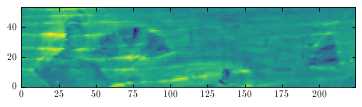

In [4]:
figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

For the large datacubes the datasize can be easily reduced using [::n,::n]
where every $n$th pixel is taken

Notes:
Please keep in mind that this rewrites the original dataset so to return the datacube must be reloaded

## Read database

##### Define Phases
This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [5]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:',len(database))

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

huntite = database['Huntite'][0]
as4 = database['As4 O6'][0]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]

phases_a_s = PhaseList([hematite,orpiment,cuprorivaite,huntite,as4])

phases_a_s.get_theta(min_intensity=min_intensity,
                 min_theta = min_theta,
                 max_theta = max_theta,
                first_n_peaks = first_n_peaks)

Phases in database: 137


(array([24.20186257, 33.23366123, 35.70970121, 40.95396191, 18.02432736,
        18.52961026, 22.36780736, 24.08297082, 28.05141062, 29.20029312,
        29.89944402, 31.25772124, 32.0519764 , 32.0867977 , 33.02687322,
        35.14225126, 36.5150204 , 36.58231021, 36.66879271, 23.52001439,
        26.53968646, 27.12076181, 27.95337296, 29.26951857, 29.80155273,
        34.13290648, 34.75120339, 38.87021431, 39.78237761, 30.93981672,
        31.56293807, 37.87212424, 29.18304822, 33.82360868, 36.963203  ]),
 array([0.37719, 1.     , 0.80322, 0.17569, 0.15815, 1.     , 0.33304,
        0.43406, 0.29864, 0.14039, 0.10435, 0.44104, 0.15273, 0.13011,
        0.63576, 0.15148, 0.1261 , 0.17155, 0.20701, 0.6209 , 0.7612 ,
        1.     , 0.36021, 0.33398, 0.95436, 0.20047, 0.29359, 0.15716,
        0.28139, 0.18786, 1.     , 0.10459, 1.     , 0.28741, 0.22397]))

PhaseMap construct a data structures for the minimization.

In [7]:
%%time

if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

pm = GammaMap().from_data(data,phases_a_s,sigma = 0.17)

CPU times: user 849 ms, sys: 87.7 ms, total: 937 ms
Wall time: 935 ms


### Autocalibration and Search
Iterates $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [8]:
%%time
pm = pm.search()

CPU times: user 12.4 s, sys: 3.72 s, total: 16.2 s
Wall time: 25.7 s


### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

In [46]:
%%time
opt = pm.opt()
a = opt[...,0]
s = opt[...,1]

CPU times: user 14.7 ms, sys: 2.79 ms, total: 17.5 ms
Wall time: 16.3 ms


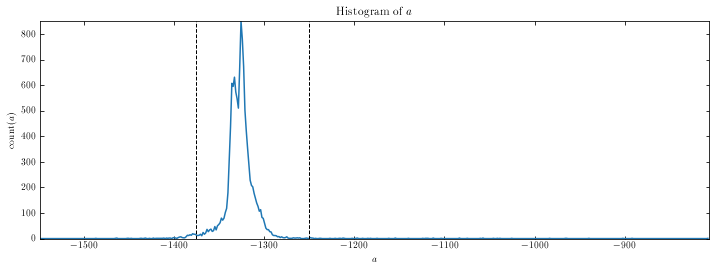

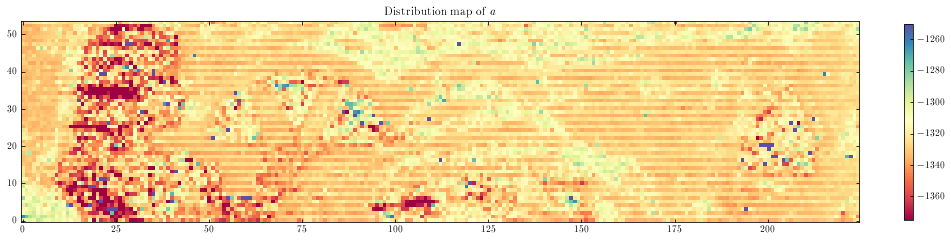

In [47]:
vmin = -1375
vmax = -1250

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [   -3.181582   -1510.63028957]
Cauchy: [ -1.77170911 357.16111801]
-1325.9764255484592 2708.0724385257163
-1325.554702699504 2705.6584605976796


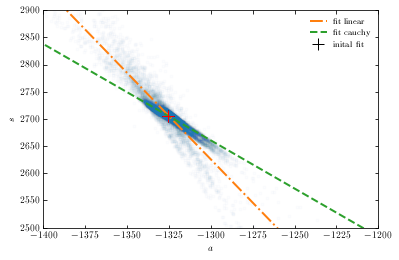

In [48]:
%matplotlib inline
#%matplotlib qt
#plot(a.flatten(),linear_y,ls='--',lw=0.5)

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

print(a.mean(),s.mean())

xlim(-1400,-1200)
ylim(2500,2900)

legend(frameon=False)

xlabel(r'$a$')
ylabel(r'$s$')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print(pmax_a,pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

### Clustering

Using clustering on measured $a$ and $s$ provides better maps

In [18]:
w1 = a.flatten()/(s.flatten()**0.5)
w2 = s.flatten()/450

X = concatenate([[w1],[w2]],axis=0).T

In [19]:
kmeans = MiniBatchKMeans(n_clusters=3,n_init=512,batch_size=2048,max_iter=512,verbose=0).fit_predict(X)

Text(0, 0.5, '$s$')

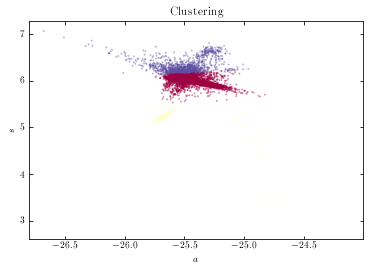

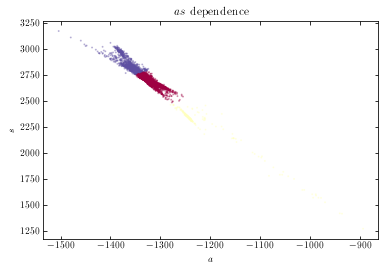

In [20]:
figure()
title('Clustering')
scatter(X[:,0],X[:,1],c=kmeans,s=1,cmap='Spectral',alpha=0.33)
xlabel(r'$a$')
ylabel(r'$s$')

figure()
title('$as$ dependence')
scatter(a.flatten(),s.flatten(),c=kmeans,s=1,cmap='Spectral',alpha=0.33)
xlabel(r'$a$')
ylabel(r'$s$')

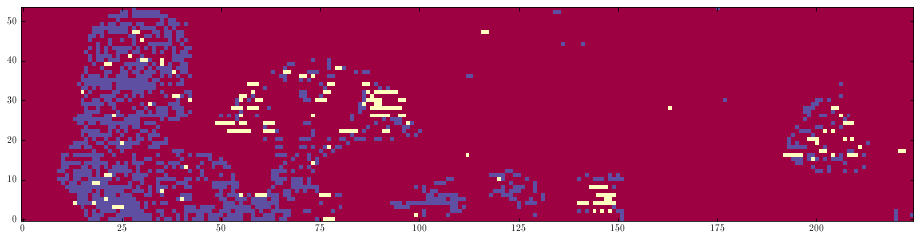

In [21]:
figure(figsize=(16,8))
imshow(kmeans.reshape(a.shape[0],a.shape[1]),cmap='Spectral')

### Fit errrors

Plotting the histograms and maps of the error for each phase. 

In [23]:
loss = sqrt(pm.loss())

AttributeError: 'GammaMap' object has no attribute 'loss'

NameError: name 'loss' is not defined

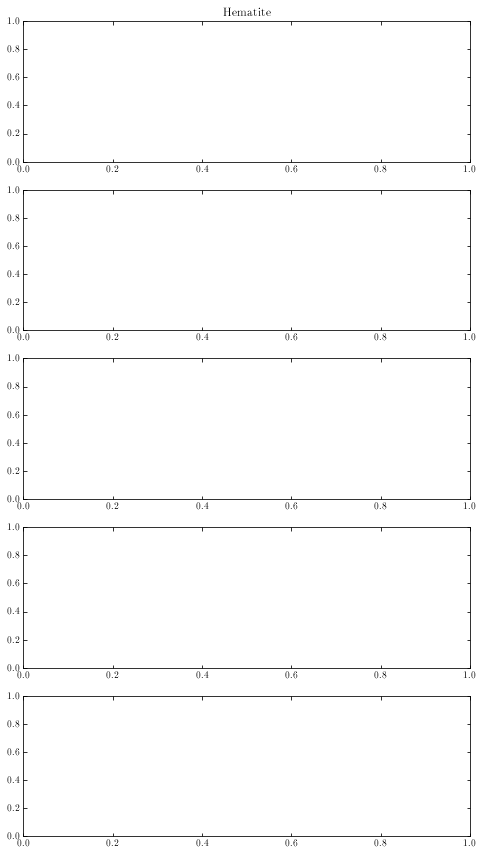

In [24]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,3*len(pm.phases)))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(loss[:,:,i],bins=512,range=(0,0.4))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,0.4)

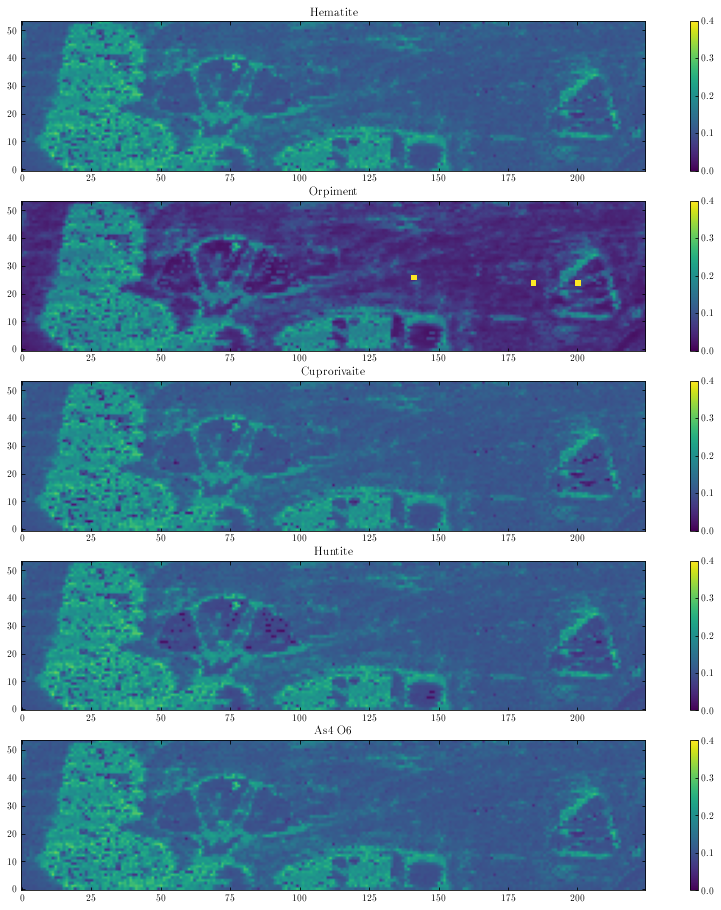

In [24]:
fig,ax = subplots(len(pm.phases),1,figsize=(16,16))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(loss[:,:,i],vmin=0,vmax=0.4)
    p = colorbar(p,ax = ax[i],fraction=0.04)

### Rescaled Loss

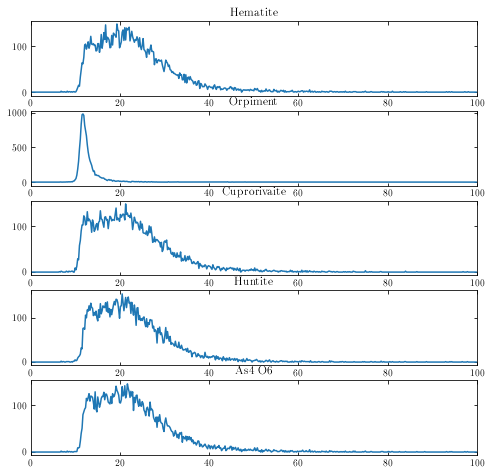

In [25]:
fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(loss_0[:,:,i],bins=512,range=(0,100))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,100)

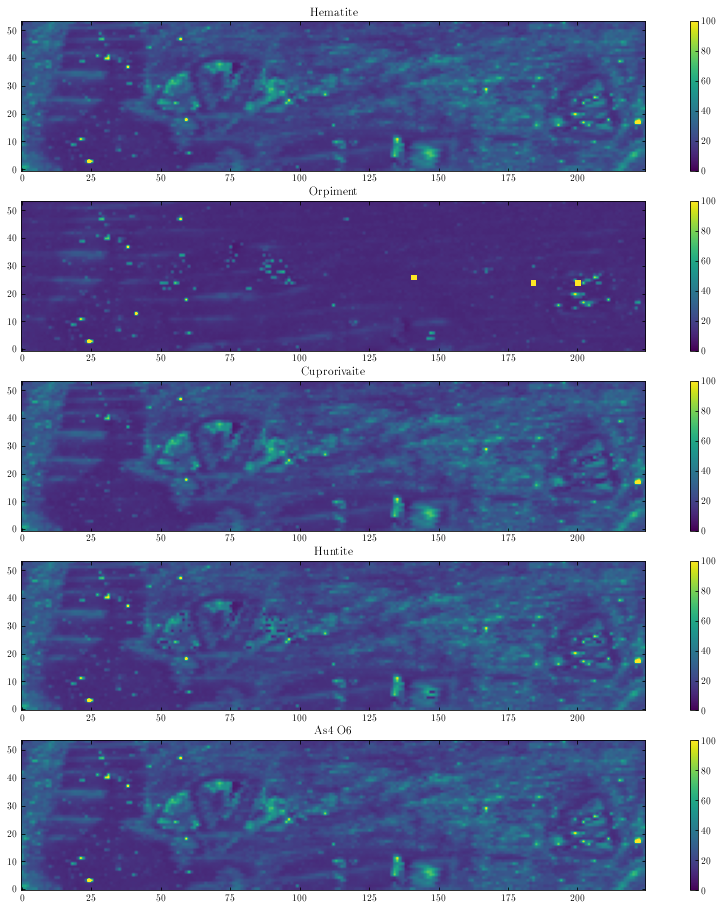

In [26]:
fig,ax = subplots(len(pm.phases),1,figsize=(16,16))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(loss_0[:,:,i],vmin=0,vmax=100)
    colorbar(p,ax = ax[i],fraction=0.04)

### Overlap Area

In [28]:
overlap_area = pm.overlap_area()

fig,ax = subplots(len(pm.phases),1,figsize=(8,8))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    h,b = histogram(overlap_area[:,:,i],bins=512,range=(0,80))
    ax[i].plot(b[:-1],h)
    ax[i].set_xlim(0,80)

AttributeError: 'GammaMap' object has no attribute 'overlap_area'

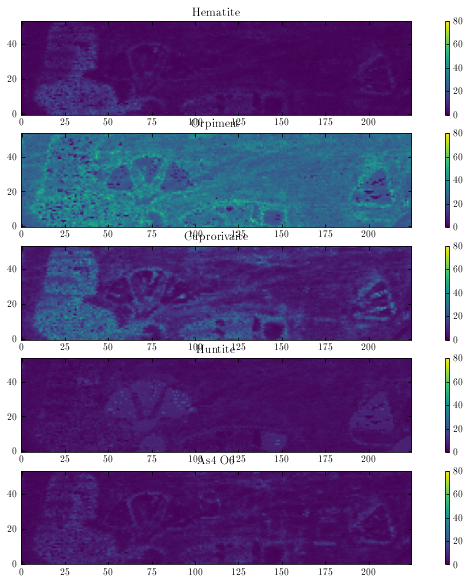

In [28]:
fig,ax = subplots(len(pm.phases),1,figsize=(12,10))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(overlap_area[:,:,i],vmin=0,vmax=80)
    colorbar(p,ax = ax[i])

[-1322.20949062  2686.72529116    43.20211896]


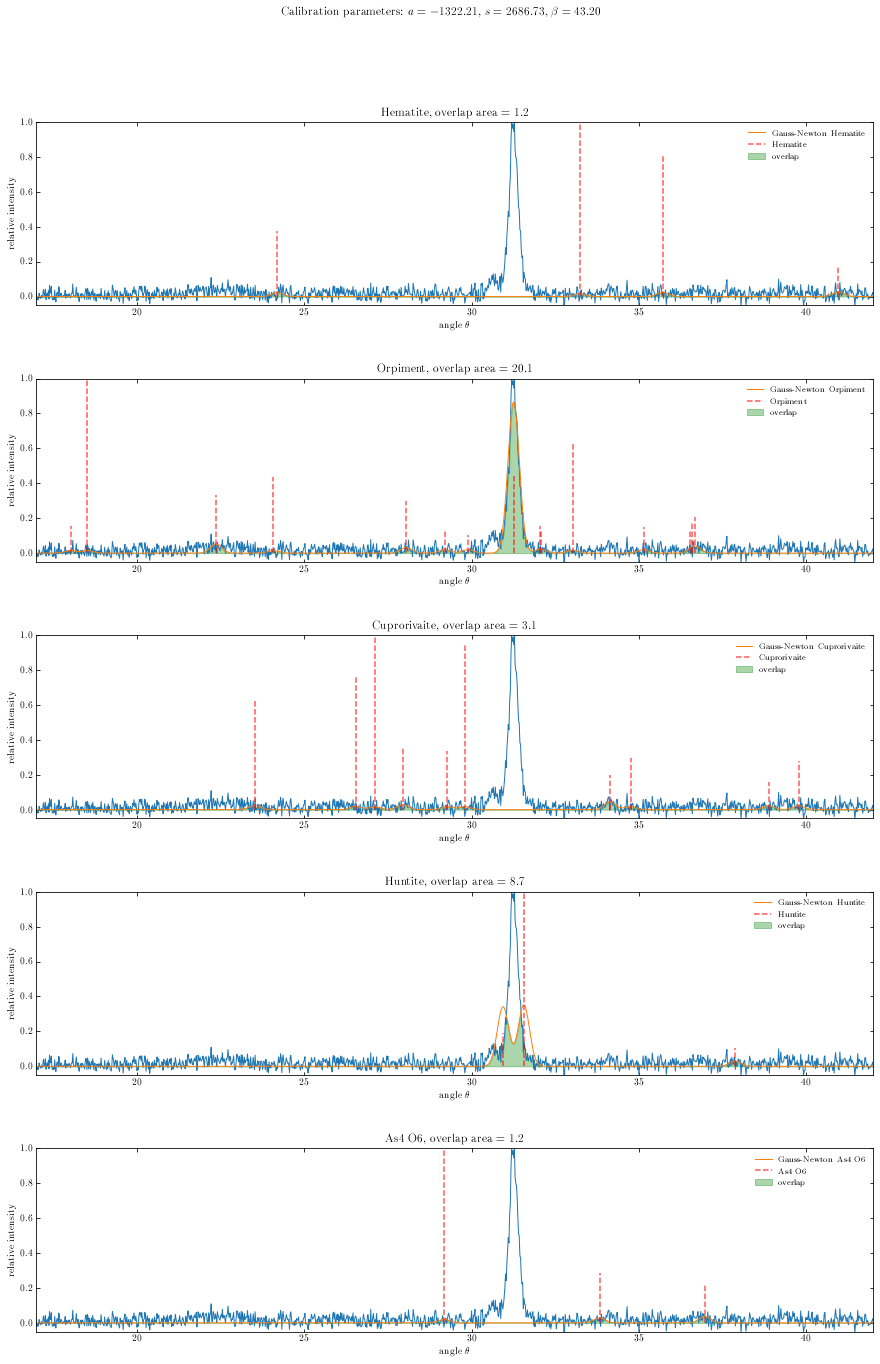

In [9]:
%matplotlib inline
selected = pm.get_pixel(73,35)
#selected = pm.get_pixel(5,5)

fig, axes = subplots(len(selected), 1, figsize = (15, 4 * len(selected)))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(selected.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(selected.opt[0], selected.opt[1], selected.opt[2]))

for i in range(len(selected)):
    ax = axes[i]
    g = selected[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(17, 42)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')

[-1305.25468849  2676.67006168    43.20211896]


Text(0, 0.5, 'relative intensity')

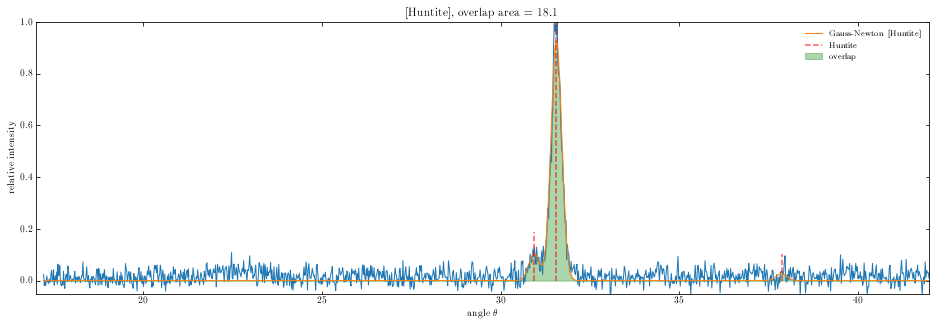

In [11]:
g = GaussNewton(PhaseList([huntite]),selected.spectrum,sigma=0.15)

g.fit_cycle(gamma=True,steps = 128,a=True,s=True)
print(g.opt)

figure(figsize=(16,5))

title(f'{g.label}, overlap area = {g.overlap_area():.1f}')

g.plot_spectra(lw = 1)
g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
g.phase.plot(color='r', alpha=0.66)

fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

legend(frameon = False)

ylim(-0.05, 1)
xlim(17, 42)
xlabel(r'angle $\theta$')
ylabel(r'relative intensity')

In [14]:
selected = array([p.idx for p in pm]).reshape(pm.shape)

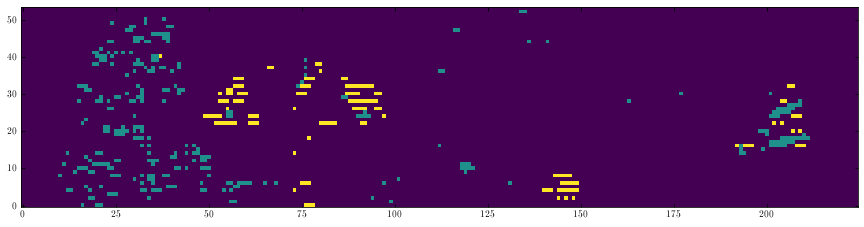

In [18]:
figure(figsize=(15,8))
imshow(selected)

In [19]:
%%time
L1loss = pm.L1loss()
MSEloss = pm.MSEloss()
overlap_area = pm.overlap_area()

CPU times: user 24.3 s, sys: 698 µs, total: 24.3 s
Wall time: 24.3 s


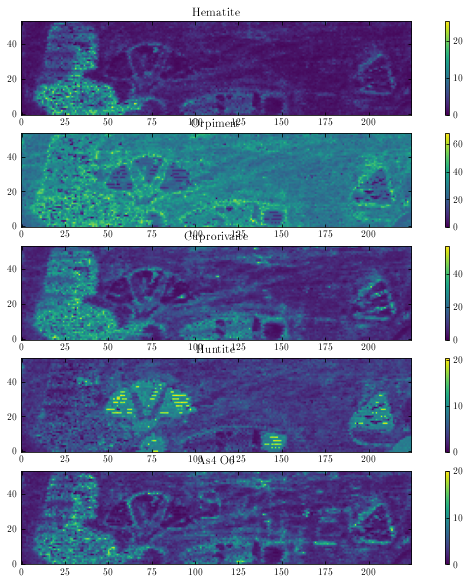

In [20]:
fig,ax = subplots(len(pm.phases),1,figsize=(12,10))

for i,phase in enumerate(pm.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(overlap_area[:,:,i],vmin=0)
    colorbar(p,ax = ax[i])